In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import shap

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split

from secondary_functions.get_metrics import concat_metrics, check_overfitting
import yaml

from tqdm import tqdm_notebook
import warnings
from typing import Any

warnings.filterwarnings('ignore')

SEED = 1618
pd.options.display.float_format ='{:,.3f}'.format

Используем гиперпараметры, подобранные при использовании optuna.

In [2]:
with open('preprocessing.yml', 'r', encoding='utf-8') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
config

{'change_type_columns': {'Рейтинг': 'float32',
  'Мощность_двигателя_лс': 'int16',
  'Пробег_км': 'int32',
  'Год_выпуска': 'int16',
  'Цена': 'int32',
  'Объём_двигателя_л': 'float32',
  'Обмен': 'int8',
  'Много_владельцев': 'int8',
  'Срок_эксплуатации': 'int8',
  'История_пробега_кол_во_записей': 'int8',
  'Владельцев_по_ПТС': 'int8',
  'Выпуск_кол_во_лет': 'int8'},
 'columns_to_drop': ['Название_авто',
  'Расположение',
  'Наименование_поколения'],
 'catb_params': {'boosting_type': 'Ordered',
  'bootstrap_type': 'Bernoulli',
  'cat_features': ['Поколение',
   'Состояние',
   'Модификация',
   'Тип_двигателя',
   'Коробка_передач',
   'Привод',
   'Комплектация',
   'Тип_кузова',
   'Цвет',
   'Руль',
   'Управление_климатом',
   'ПТС',
   'Бренд_авто',
   'Модель_авто',
   'Город',
   'Федеральный_округ',
   'Степень_износа'],
  'colsample_bylevel': 0.07016296475032051,
  'depth': 12,
  'eval_metric': 'MAE',
  'iterations': 3000,
  'l2_leaf_reg': 12.236324946000956,
  'learning_ra

# Загрузка датасета, получение тренировочных и тестовых данных, оптимизация по памяти.

In [3]:
df_train = pd.read_csv('./data_store/train.csv').astype(
    config['change_type_columns'])
df_test = pd.read_csv('./data_store/test.csv').astype(
    config['change_type_columns'])
df_train[df_train.select_dtypes('object').columns] = df_train[
    df_train.select_dtypes('object').columns].astype('category')
df_test[df_test.select_dtypes('object').columns] = df_test[
    df_test.select_dtypes('object').columns].astype('category')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31547 entries, 0 to 31546
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Рейтинг                         31547 non-null  float32 
 1   Цена                            31547 non-null  int32   
 2   Год_выпуска                     31547 non-null  int16   
 3   Пробег_км                       31547 non-null  int32   
 4   История_пробега_кол_во_записей  31547 non-null  int8    
 5   Владельцев_по_ПТС               31547 non-null  int8    
 6   Объём_двигателя_л               31547 non-null  float32 
 7   Выпуск_кол_во_лет               31547 non-null  int8    
 8   Мощность_двигателя_лс           31547 non-null  int16   
 9   Поколение                       31547 non-null  category
 10  Состояние                       31547 non-null  category
 11  Модификация                     31547 non-null  category
 12  Тип_двигателя     

In [5]:
X_train, y_train = df_train.drop('Цена', axis=1),  df_train['Цена'] 
X_test, y_test = df_test.drop('Цена', axis=1), df_test['Цена']

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.1,
                                                    shuffle=True,
                                                    random_state=SEED)
cat_feature_names = list(X_train.select_dtypes('category').columns)

# Evaluating.

In [6]:
tuned_catb = CatBoostRegressor(**config['catb_params'])
tuned_lgbm = LGBMRegressor(**config['lgbm_params'])
tuned_catb.fit(X_train_,
               y_train_,
               eval_set=[(X_val, y_val)],
               early_stopping_rounds=50)
tuned_lgbm.fit(X_train_,
               y_train_,
               eval_set=[(X_val, y_val)],
               eval_metric='mae')
catb_preds = tuned_catb.predict(X_test)[:, 0]
lgbm_preds = tuned_lgbm.predict(X_test)

In [7]:
check_overfitting(X_train, y_train, X_test, y_test, tuned_catb)

CatBoostRegressor 
MAE train: 174471.67201453762 
MAE test: 218035.49506158888 
MAE diff: 19.98 %


In [8]:
check_overfitting(X_train, y_train, X_test, y_test, tuned_lgbm)

LGBMRegressor 
MAE train: 171616.12320457425 
MAE test: 218012.28818386074 
MAE diff: 21.28 %


In [9]:
metrics= pd.DataFrame()
metrics = concat_metrics(
    metrics,
    y_train.values,
    tuned_catb.predict(X_train)[:, 0],
    X_train,
    model_name=f'{tuned_catb.__class__.__name__}_tuned_train')
metrics = concat_metrics(
    metrics,
    y_test.values,
    catb_preds,
    X_test,
    model_name=f'{tuned_catb.__class__.__name__}_tuned_test')
metrics = concat_metrics(
    metrics,
    y_train.values,
    tuned_lgbm.predict(X_train),
    X_train,
    model_name=f'{tuned_lgbm.__class__.__name__}_tuned_train')
metrics = concat_metrics(
    metrics,
    y_test.values,
    lgbm_preds,
    X_test,
    model_name=f'{tuned_lgbm.__class__.__name__}_tuned_test')
metrics

,Модель,MAE,R2_Adjusted,WAPE,RMSE
0,CatBoostRegressor_tuned_train,"174,471.672",0.979,262.349,"350,559.219"
0,CatBoostRegressor_tuned_test,"218,035.495",0.960,73.707,"445,168.911"
0,LGBMRegressor_tuned_train,"171,616.123",0.978,258.055,"358,138.888"
0,LGBMRegressor_tuned_test,"218,012.288",0.960,73.699,"441,183.265"


**Вывод**: фаворитом в текущих сравнениях стал LGBM. Меньшие ошибки, лучше коэффициент детерминации, на порядок быстрее обучение, несмотря на большее количество деревьев в алгоритме (на 30% - 4000 против 3000 у Catboost).

# Feature importances.

Отлично! Теперь посмотрим на самые важные признаки, которые оказывают наибольшее влияние на предсказания модели.

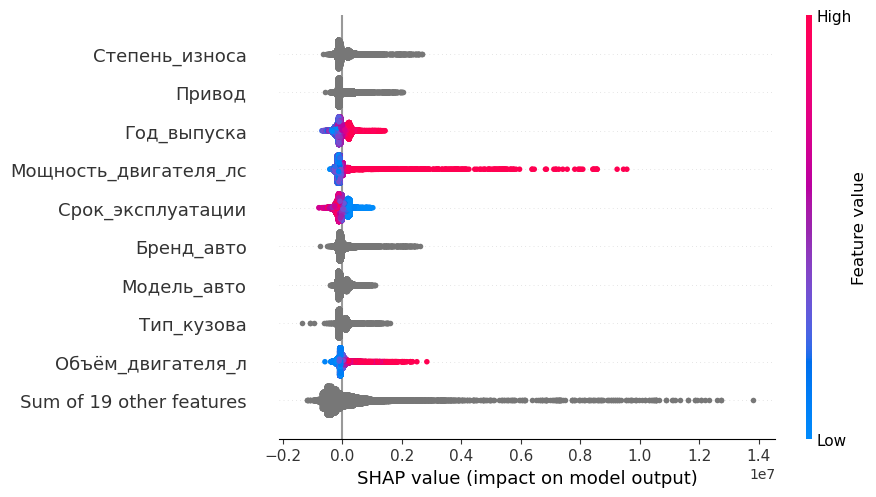

In [10]:
explainer_catb = shap.TreeExplainer(tuned_catb)
explanation_catb = explainer_catb(X_train)
shap.plots.beeswarm(explanation_catb[:, :, 0])

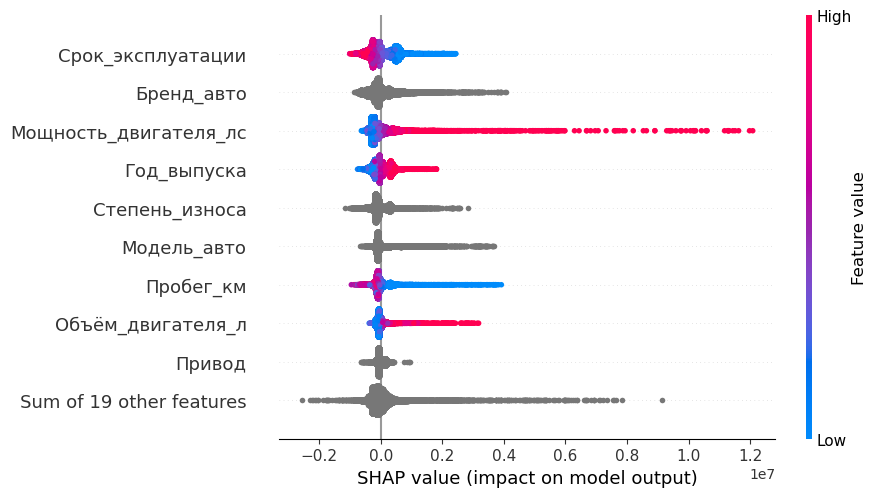

In [11]:
explainer_lgbm = shap.TreeExplainer(tuned_lgbm)
explanation_lgbm = explainer_lgbm(X_train)
shap.plots.beeswarm(explanation_lgbm)

Ключевые признаки у моделей сильно схожи. Наиболее важные признаки - Год_выпуска, Мощность_двигателя, Срок_эксплуатации. Это логично - чем, больше срок эксплуатации и чем меньше год выпуска, тем больше износ авто и как следствие ниже цена, что мы и наблюдаем на графике. Больший объём подразумевает больше мощность, что зачастую присуще более дорогим авто. Срок_эксплуатации и Год_выпуска связаны - чем меньше срок эксплуатации и больше год выпуска, тем больше цена. Хотя LGBM выделил в отличие от Catboost дополнительно пробег в качестве важного признака. Мощность также связана с объёмом двигателя и также прямо коррелирует с ценой - чем больше тем дороже.

**Вывод:** Обе модели имеют свои плюсы и минусы. Результативность моделей очень сильно менялась, в зависимости от размера исходного датасета, при первых экспериментах было около 27000 объектов, и лучше всех показывали себя RandomForest и XGB. Когда данных стало 32000 пальму первенства забрал LGBM. А при текущем размере в 37000 первое место делят Catboost и LightGBM. Если собрать еще больше данных, можно значительно улучшить качество.